In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**데이터 전처리**

In [31]:
labeled_data = pd.read_csv("/content/drive/MyDrive/KUIAI/molding/labeled_data.csv")

#데이터 유일성 --> 0.65로 만족 안함
a = len(labeled_data["_id"].unique())
print(a/len(labeled_data))

result = labeled_data.drop_duplicates()

a = len(result["_id"].unique())
print(a/len(result))

labeled_data = result

# 데이터 완전성 -> 100%
labeled_data.isna().sum()

# 데이터 유효성: 유효정보에 대한 접근이 없어서 시간 데이터 형식만 바꾼다
labeled_data['TimeStamp'] = pd.to_datetime(labeled_data['TimeStamp'],format='%Y-%m-%dT%H:&M:SZ',errors="coerce")
labeled_data['PART_FACT_PLAN_DATE'] = pd.to_datetime(labeled_data['PART_FACT_PLAN_DATE'],format='%Y-%m-%d 오전 12:00:00',errors="coerce")

# 데이터 정확성 : PassOrFail & reason과의 상관관계 보기
labeled_data["Reason"].unique()
labeled_data["PassOrFail"].unique()

a = labeled_data['Reason'] == "None"
b = labeled_data['PassOrFail'] == "Y" # 정상이라면 불량 난 이유를 굳이 써줄 이유 없음
# 정상 == 정상?
print(len(labeled_data[a])-len(labeled_data[b]))

a = labeled_data['Reason'] != "None"
b = labeled_data['PassOrFail'] != "Y" # 정상이라면 불량 난 이유를 굳이 써줄 이유 없음
# 비정상 == 비정상?
print(len(labeled_data[a])-len(labeled_data[b]))

0.6543271635817909
1.0
0
0


# **데이터 selection**

In [32]:
labeled_data["EQUIP_NAME"].value_counts()
labeled_data["PART_NAME"].value_counts()

def delete_column(data, machine_name,product_name):
  machine_ = data["EQUIP_NAME"] == machine_name
  product_ = data["PART_NAME"] == product_name
  data = data[machine_ & product_]

  data.drop(['_id', 'TimeStamp', 'PART_FACT_PLAN_DATE', 'PART_FACT_SERIAL',
       'PART_NAME', 'EQUIP_CD', 'EQUIP_NAME', 'Reason',
       'Mold_Temperature_1', 'Mold_Temperature_2', 'Mold_Temperature_5', 'Mold_Temperature_6',
       'Mold_Temperature_7', 'Mold_Temperature_8', 'Mold_Temperature_9',
       'Mold_Temperature_10', 'Mold_Temperature_11', 'Mold_Temperature_12'],
       axis=1,inplace=True)
  return data

machine_name ="650톤-우진2호기"
product_name = ["CN7 W/S SIDE MLD'G RH","CN7 W/S SIDE MLD'G LH","RG3 MOLD'G W/SHLD, RH","RG3 MOLD'G W/SHLD, LH " ]

cn7_rh = delete_column(labeled_data, machine_name,product_name[0])
cn7_lh = delete_column(labeled_data, machine_name,product_name[1])
rg3_rh = delete_column(labeled_data, machine_name,product_name[2])
rg3_lh = delete_column(labeled_data, machine_name,product_name[3])

cn7 = pd.concat([cn7_lh,cn7_rh])
rg3 = pd.concat([rg3_lh,rg3_rh])

# pass or fail 을 각각 0 ,1 으로 바꾸기
cn7["PassOrFail"] = cn7["PassOrFail"].replace("Y",1).replace("N",0)
rg3["PassOrFail"] = rg3["PassOrFail"].replace("Y",1).replace("N",0)

cn7['Switch_Over_Position'].unique()
cn7['Barrel_Temperature_7'].unique()

# Switch_Over_Position, Barrel_Temperature_7의 값이 모두 unique함으로 cn7에서 위 두 칼럽을 지운다
cn7.drop(["Switch_Over_Position","Barrel_Temperature_7"],axis=1,inplace=True)

rg3['Switch_Over_Position'].unique()
rg3["Clamp_Open_Position"].unique()
rg3.drop(["Switch_Over_Position","Clamp_Open_Position","Barrel_Temperature_7"],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [33]:
# 불량 정상 갯수 확인

cn7_Y = cn7[cn7["PassOrFail"]==1]
cn7_N = cn7[cn7["PassOrFail"]==0]

print(f"cn7의 정상품 수 {len(cn7_Y)}  cn7의 불량품 수 {len(cn7_N)}")

rg3_Y = rg3[rg3["PassOrFail"]==1]
rg3_N = rg3[rg3["PassOrFail"]==0]

print(f"rg3의 정상품 수 {len(rg3_Y)}  rg3의 불량품 수 {len(rg3_N)}")

# 독립변수와 종속변수의 구분

cn7_y = cn7["PassOrFail"]
cn7_x = cn7.iloc[:,1:]
cn7_Y_y = cn7_Y["PassOrFail"]
cn7_N_y = cn7_N["PassOrFail"]
cn7_Y_x = cn7_Y.iloc[:,1:]
cn7_N_x = cn7_N.iloc[:,1:]

rg3_y = rg3["PassOrFail"]
rg3_x = rg3.iloc[:,1:]
rg3_Y_y = rg3_Y["PassOrFail"]
rg3_N_y = rg3_N["PassOrFail"]
rg3_Y_x = rg3_Y.iloc[:,1:]
rg3_N_x = rg3_N.iloc[:,1:]

# 데이터 스케일링
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

cn7_x = scaler.fit_transform(cn7_x)
cn7_Y_x = scaler.fit_transform(cn7_Y_x)
cn7_N_x = scaler.fit_transform(cn7_N_x)

rg3_x = scaler.fit_transform(rg3_x)
rg3_Y_x = scaler.fit_transform(rg3_Y_x)
rg3_N_x = scaler.fit_transform(rg3_N_x)

cn7의 정상품 수 3946  cn7의 불량품 수 28
rg3의 정상품 수 601  rg3의 불량품 수 27


In [34]:
# 각 변수들의 설명력이 너무 약해서 차원축소
from sklearn.decomposition import KernelPCA, PCA
pca = PCA() #주성분 개수 지정하지 않고 클래스생성

pca.fit(cn7_x)  #주성분 분석
cumsum = np.cumsum(pca.explained_variance_ratio_) #분산의 설명량을 누적합
num_c = np.argmax(cumsum >= 0.95) + 1 # 분산의 설명량이 95%이상 되는 차원의 수
pca = PCA(n_components = num_c)

cn7_Y_x = pca.fit_transform(cn7_Y_x)
cn7_N_x = pca.fit_transform(cn7_N_x)

pca2 = PCA()
pca2.fit(rg3_x)  #주성분 분석
cumsum = np.cumsum(pca2.explained_variance_ratio_) #분산의 설명량을 누적합
num_r = np.argmax(cumsum >= 0.95) + 1 # 분산의 설명량이 95%이상 되는 차원의 수
pca2 = PCA(n_components = num_r)
print(num_r)

rg3_Y_x = pca2.fit_transform(rg3_Y_x)
rg3_N_x = pca2.fit_transform(rg3_N_x)

4
12


# **cn7**

training data
test data 

In [35]:
import numpy as np
import pandas as pd
import scipy
from sklearn.ensemble import IsolationForest
from imblearn.over_sampling import SMOTE

cn7_train = cn7_Y_x[:2400]
cn7_test_Y = cn7_Y_x[2400:]
cn7_test_N = cn7_N_x
cn7_test_Y_y = cn7_Y_y[2400:]
cn7_test_N_y = cn7_N_y

rg3_train = rg3_Y_x[:380]
rg3_test_Y = rg3_Y_x[380:]
rg3_test_N = rg3_N_x
rg3_test_Y_y = rg3_Y_y[380:]
rg3_test_N_y = rg3_N_y

#define hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import time

param_grid = {
    'contamination': [0.0001, 0.001, 0.01, 0.1],
    'bootstrap': [True, False],
    'n_estimators': [50, 70, 80, 100]
}

model = IsolationForest()
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv= 5)
gs = gs.fit(cn7_x[2400:], cn7_y[2400:])
gs.best_params_

{'bootstrap': True, 'contamination': 0.0001, 'n_estimators': 50}

In [46]:
clf = IsolationForest(n_estimators = 50, # The number of base estimators in the ensemble
                      contamination = 0.0001, # the proportion of outliers in the data set
                      bootstrap = True
                      )
start = time.time()
clf.fit(cn7_train)
print("학습시간 :", time.time() - start)

start2 = time.time()
cn7_pred_train = clf.predict(cn7_train)
cn7_pred_test_Y = clf.predict(cn7_test_Y)
cn7_pred_test_N = clf.predict(cn7_test_N)
cn7_pred_test_N = pd.DataFrame(cn7_pred_test_N).replace({1:0, -1:1})
print("예측시간 :", time.time() - start2)

from sklearn.tree import export_graphviz

model = clf.estimators_[3]

#.dot file로 export
export_graphviz(model, out_file = 'tree.dot')

#.dot file을 .png로 변환
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'iForest-tree.png', '-Gdpi=600'])

#.png 출력
from IPython.display import Image
Image(filename = 'iForest-tree.png')

학습시간 : 0.12898564338684082
예측시간 : 0.11228132247924805


for normal data
confusion matrix
 [[1546]]
Accuracy:  1.0
classification_report
               precision    recall  f1-score   support

           1       1.00      1.00      1.00      1546

    accuracy                           1.00      1546
   macro avg       1.00      1.00      1.00      1546
weighted avg       1.00      1.00      1.00      1546



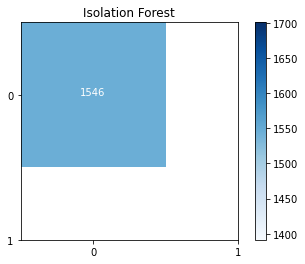


---------------------------------------------------
for abnormal data
confusion matrix
 [[28]]
Accuracy:  1.0
classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        28

    accuracy                           1.00        28
   macro avg       1.00      1.00      1.00        28
weighted avg       1.00      1.00      1.00        28



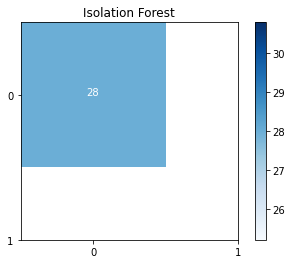

In [37]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

class_name = [0, 1]
def plot_confusion_matrix(classes, pred, y_test, 
                          normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_test, pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.show()


# 평가
print("for normal data")
print('confusion matrix\n', confusion_matrix(cn7_pred_test_Y, cn7_test_Y_y))
print('Accuracy: ',accuracy_score(cn7_pred_test_Y, cn7_test_Y_y))
print('classification_report\n', classification_report(cn7_pred_test_Y, cn7_test_Y_y))
plot_confusion_matrix(class_name, cn7_pred_test_Y, cn7_test_Y_y, title='Isolation Forest')
print()
print("---------------------------------------------------")
print("for abnormal data")
print('confusion matrix\n', confusion_matrix(cn7_pred_test_N, cn7_test_N_y))
print('Accuracy: ',accuracy_score(cn7_pred_test_N, cn7_test_N_y))
print('classification_report\n', classification_report(cn7_pred_test_N, cn7_test_N_y))
plot_confusion_matrix(class_name, cn7_pred_test_N, cn7_test_N_y, title='Isolation Forest')

# **RG3**

In [38]:
#define hyperparameter
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, make_scorer
import time

param_grid = {
    'contamination': [0.0001, 0.001, 0.01, 0.1],
    'bootstrap': [True, False],
    'n_estimators': [50, 70, 80, 100]
}

model = IsolationForest()
gs = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv= 5)
gs = gs.fit(rg3_x[380:], rg3_y[380:])
gs.best_params_

{'bootstrap': False, 'contamination': 0.0001, 'n_estimators': 80}

In [45]:
#define % of anomalies
anomalies_ratio = 0.009

clf = IsolationForest(n_estimators = 80, # The number of base estimators in the ensemble
                        contamination = 0.0001, # the proportion of outliers in the data set
                        bootstrap = False)

start = time.time()
clf.fit(rg3_train)
print("학습시간 :", time.time() - start)

start2 = time.time()
rg3_pred_train = clf.predict(rg3_train)
rg3_pred_test_Y = clf.predict(rg3_test_Y)
rg3_pred_test_N = clf.predict(rg3_test_N)
rg3_pred_test_N = pd.DataFrame(rg3_pred_test_N).replace({1:0, -1:1})
print("예측시간 :", time.time() - start2)

from sklearn.tree import export_graphviz

model = clf.estimators_[3]

#.dot file로 export
export_graphviz(model, out_file = 'tree.dot')

#.dot file을 .png로 변환
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'iForest-tree.png', '-Gdpi=600'])

#.png 출력
from IPython.display import Image
Image(filename = 'iForest-tree.png')

학습시간 : 0.1476593017578125
예측시간 : 0.1302504539489746


for normal data
confusion matrix
 [[  0   3]
 [  0 218]]
Accuracy:  0.9864253393665159
classification_report
               precision    recall  f1-score   support

          -1       0.00      0.00      0.00         3
           1       0.99      1.00      0.99       218

    accuracy                           0.99       221
   macro avg       0.49      0.50      0.50       221
weighted avg       0.97      0.99      0.98       221



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


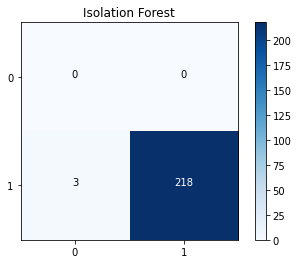


---------------------------------------------------
for abnormal data
confusion matrix
 [[27]]
Accuracy:  1.0
classification_report
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        27

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27



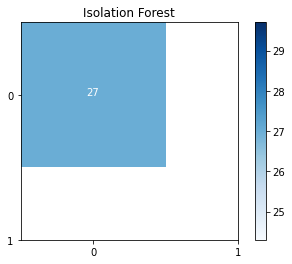

In [41]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import itertools

class_name = [0, 1]
def plot_confusion_matrix(classes, pred, y_test, 
                          normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    
    cm = confusion_matrix(y_test, pred)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
        
    plt.show()


# 평가
print("for normal data")
print('confusion matrix\n', confusion_matrix(rg3_pred_test_Y, rg3_test_Y_y))
print('Accuracy: ',accuracy_score(rg3_pred_test_Y, rg3_test_Y_y))
print('classification_report\n', classification_report(rg3_pred_test_Y, rg3_test_Y_y))
plot_confusion_matrix(class_name, rg3_pred_test_Y, rg3_test_Y_y, title='Isolation Forest')
print()
print("---------------------------------------------------")
print("for abnormal data")
print('confusion matrix\n', confusion_matrix(rg3_pred_test_N, rg3_test_N_y))
print('Accuracy: ',accuracy_score(rg3_pred_test_N, rg3_test_N_y))
print('classification_report\n', classification_report(rg3_pred_test_N, rg3_test_N_y))
plot_confusion_matrix(class_name, rg3_pred_test_N, rg3_test_N_y, title='Isolation Forest')